In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import numpy as np
import glob, shutil
import timeit, os, gc
import subprocess as sp
from tqdm import tqdm
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import json
from IPython.display import HTML
from base64 import b64encode
import cv2

time: 601 ms


In [15]:
import seaborn as sns

time: 495 ms


In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 4000)
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set(font_scale=1.0)

c:\users\jamesjun\anaconda3\envs\dfchallenge\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


time: 336 ms


In [6]:
#clean_faces_pd = pd.merge(all_faces_pd, train_pd, on="filename", how="left")
clean_faces_pd = pd.read_pickle("D:/CueLearning/DFData/all_faces_df.pkl")
clean_faces_pd.head()

,filename,image,faces_retina,label,split,original,thresh_boxes_retina,block
0,vpmyeepbep.mp4,output_0001.png,1,REAL,train,NaN,"[((667, 600, 767, 751), 0.9984279870986938)]",0
1,vpmyeepbep.mp4,output_0002.png,1,REAL,train,NaN,"[((667, 600, 767, 751), 0.9984278678894043)]",0
2,vpmyeepbep.mp4,output_0003.png,1,REAL,train,NaN,"[((678, 600, 776, 749), 0.9989476799964905)]",0
3,vpmyeepbep.mp4,output_0004.png,1,REAL,train,NaN,"[((678, 601, 774, 757), 0.9987552165985107)]",0
4,vpmyeepbep.mp4,output_0005.png,1,REAL,train,NaN,"[((659, 607, 759, 754), 0.9983761310577393)]",0


time: 7.86 s


In [9]:
# Find out face width/height
def faces_max_item(boxes, idx1, idx2):
    ret = 0
    if len(boxes) > 0:
        ret = max(boxes, key=lambda item: item[idx1][idx2])[idx1][idx2]
    return ret

def faces_max_confidence(boxes):
    ret = 0
    if len(boxes) > 0:
        ret = max(boxes, key=lambda item: item[1])[1]
    return ret

def faces_min_confidence(boxes):
    ret = 0
    if len(boxes) > 0:
        ret = min(boxes, key=lambda item: item[1])[1]
    return ret


# To filter faces with a confidence lower than threshold
def faces_threshold(boxes, conf_thresh = 0.96):
    ret = [] 
    if len(boxes) > 0:
        for i in range(len(boxes)):
            if boxes[i][1] > conf_thresh:
                ret.append(boxes[i])
    
    return ret

def number_of_faces(boxes):
    ret = len(boxes)
    
    return ret

def maximum_number_of_faces(boxes, max_num = 2):
    # Faces are sorted from higher to lower confidence
    # since there are maximum two faces  per video we want to remove the third or 4th value
    
    ret = [] 
    if len(boxes) > max_num:
        for i in range(max_num):    
            ret.append(boxes[i])
    else:
        for i in range(len(boxes)):    
            ret.append(boxes[i])
    
    return ret
    

def fixed_cropping(boxes, w_def = 350, h_def = 450):
    ret = []
    for i in range(len(boxes)):
        original_box = list(boxes[i][0])
        w_box = original_box[2] - original_box[0]
        h_box = original_box[3] - original_box[1]
        c1 = w_box/2 + original_box[0]
        c2= h_box/2 + original_box[1]
        
        large_box = []
        large_box.append(int(c1- w_def/2  ))
        large_box.append(int( c2 - h_def/2 ))
        large_box.append(int( w_def/2+ c1))
        large_box.append(int(h_def/2 + c2))
        
        large_box_tuple = tuple(large_box)
        o = [large_box_tuple, boxes[i][1]]
        n = tuple(o)
        ret.append(n)
             
    return ret

def no_negative_values_in_boxes(boxes, video_height, video_width):
    
    ret = []
    for i in range(len(boxes)):
        final_box = []
        original_box = list(boxes[i][0])
        
        if original_box[0] < 0:
            final_box.append(0)
        else:
            final_box.append(original_box[0])
            
            
        if original_box[1] < 0:
            final_box.append(0)
        else:
            final_box.append(original_box[1])
            
        if original_box[2] < 0:
            final_box.append(video_width)
        else:
            final_box.append(original_box[2])
            
        if original_box[3] < 0:
            final_box.append(video_height)
        else:
            final_box.append(original_box[3])
            
            
        
        final_box_tuple = tuple(final_box)
        o = [final_box_tuple, boxes[i][1]]
        n = tuple(o)
        ret.append(n)
        
    return ret
    

#clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["boxes_retina"].apply(lambda x: faces_threshold(x))
#clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: maximum_number_of_faces(x))
#clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: no_negative_values_in_boxes(x, clean_faces_pd["video_height"], clean_faces_pd["video_width"]))
clean_faces_pd["faces_max_width"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_item(x, 0, 2) - faces_max_item(x, 0, 0)) 
clean_faces_pd["faces_max_height"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_item(x, 0, 3) -faces_max_item(x, 0, 1))
clean_faces_pd["faces_max_conf"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_confidence(x))
clean_faces_pd["faces_min_conf"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_min_confidence(x))
clean_faces_pd["faces_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: number_of_faces(x))
#clean_faces_pd["fixed_cropping"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: fixed_cropping(x))

time: 1min


In [10]:
clean_faces_pd.head()

,filename,image,faces_retina,label,split,original,thresh_boxes_retina,block,faces_max_width,faces_max_height,faces_max_conf,faces_min_conf,fixed_cropping
0,vpmyeepbep.mp4,output_0001.png,1,REAL,train,NaN,"[((667, 600, 767, 751), 0.9984279870986938)]",0,100,151,0.998428,0.998428,"[((542, 450, 892, 900), 0.9984279870986938)]"
1,vpmyeepbep.mp4,output_0002.png,1,REAL,train,NaN,"[((667, 600, 767, 751), 0.9984278678894043)]",0,100,151,0.998428,0.998428,"[((542, 450, 892, 900), 0.9984278678894043)]"
2,vpmyeepbep.mp4,output_0003.png,1,REAL,train,NaN,"[((678, 600, 776, 749), 0.9989476799964905)]",0,98,149,0.998948,0.998948,"[((552, 449, 902, 899), 0.9989476799964905)]"
3,vpmyeepbep.mp4,output_0004.png,1,REAL,train,NaN,"[((678, 601, 774, 757), 0.9987552165985107)]",0,96,156,0.998755,0.998755,"[((551, 454, 901, 904), 0.9987552165985107)]"
4,vpmyeepbep.mp4,output_0005.png,1,REAL,train,NaN,"[((659, 607, 759, 754), 0.9983761310577393)]",0,100,147,0.998376,0.998376,"[((534, 455, 884, 905), 0.9983761310577393)]"


time: 38 ms


In [11]:
# How many faces did we detect?
clean_faces_pd.groupby(["faces_retina"]).count()

,filename,image,label,split,original,thresh_boxes_retina,block,faces_max_width,faces_max_height,faces_max_conf,faces_min_conf,fixed_cropping
faces_retina,,,,,,,,,,,,
1,3393154,3393154,3393154,3393154,2843572,3393154,3393154,3393154,3393154,3393154,3393154,3393154
2,367410,367410,367410,367410,316254,367410,367410,367410,367410,367410,367410,367410


time: 2.44 s


In [13]:
clean_faces_pd["faces_retina_avg"] = clean_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmean)
clean_faces_pd["faces_retina_median"] = clean_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmedian)

time: 1.47 s


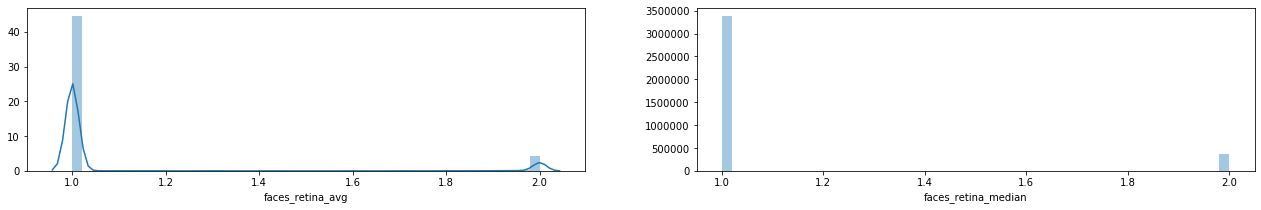

time: 21.4 s


In [16]:
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_retina_avg"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_retina_median"], kde=False, ax=ax[1])

Faces stats:
       faces_max_width  faces_max_height  faces_min_conf  faces_max_conf
count  3.760564e+06     3.760564e+06      3.760564e+06    3.760564e+06  
mean   1.446661e+02     1.972416e+02      9.988104e-01    9.990318e-01  
std    5.195881e+01     7.236713e+01      2.453771e-03    1.479232e-03  
min    1.300000e+01     1.500000e+01      9.300323e-01    9.321471e-01  
1%     5.800000e+01     7.700000e+01      9.902693e-01    9.943350e-01  
5%     7.400000e+01     9.500000e+01      9.969378e-01    9.976138e-01  
10%    8.300000e+01     1.120000e+02      9.980471e-01    9.983839e-01  
25%    9.800000e+01     1.330000e+02      9.988985e-01    9.989910e-01  
50%    1.410000e+02     1.900000e+02      9.992849e-01    9.993192e-01  
75%    1.840000e+02     2.560000e+02      9.995080e-01    9.995266e-01  
90%    2.160000e+02     2.930000e+02      9.996539e-01    9.996672e-01  
95%    2.320000e+02     3.170000e+02      9.997280e-01    9.997422e-01  
99%    2.570000e+02     3.530000e+02  

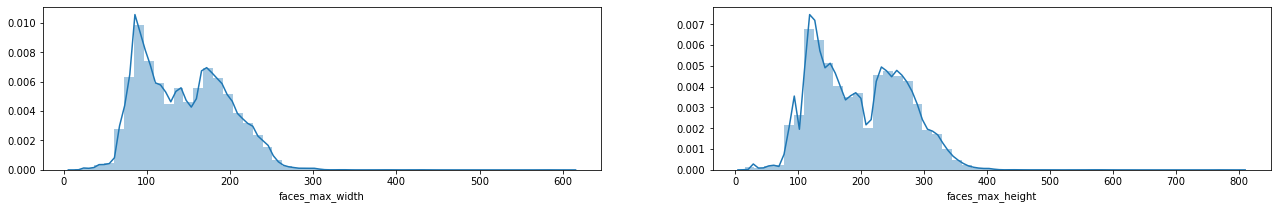

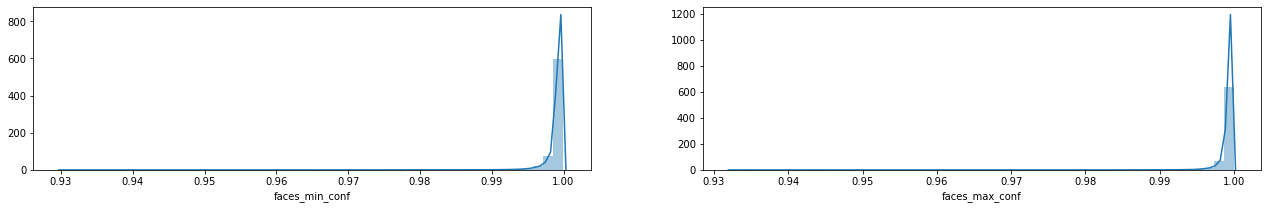

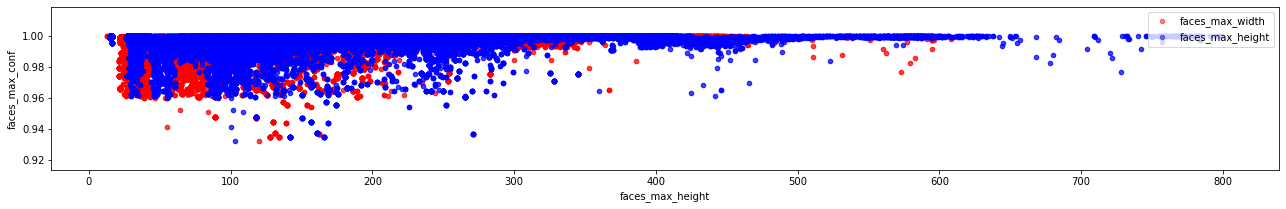

time: 2min 50s


In [17]:
# If we train a CNN, we will have to define a width/height. 256x256 or 320x320 looks good.
print("Faces stats:")
print(clean_faces_pd[["faces_max_width", "faces_max_height", "faces_min_conf", "faces_max_conf"]].describe(percentiles=[0.01,0.05, 0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_max_width"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_max_height"], kde=True, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_min_conf"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_max_conf"], kde=True, ax=ax[1])
fig, ax = plt.subplots(figsize=(22, 3))
d = clean_faces_pd.plot(kind="scatter", x="faces_max_width", y="faces_max_conf", c="red", ax=ax, label="faces_max_width", alpha=0.5)
d = clean_faces_pd.plot(kind="scatter", x="faces_max_height", y="faces_max_conf", c="blue", ax=d,  label="faces_max_height", alpha=0.5)
d = plt.legend(loc="upper right")